In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [146]:
# changing present working directory
import os
import sys

os.chdir("/content/drive/My Drive/Capstone_Project/")
sys.path.append('/content/drive/My Drive/Capstone_Project/') # Add DataPreprocessor.py directory path to sys.path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline
import seaborn as sns
sns.set(style="ticks", color_codes=True)
sns.set_palette("Spectral")
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer

from pprint import pprint
from sklearn import preprocessing 
import string 
import re


import warnings
warnings.filterwarnings(action='ignore')

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC

from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from mlxtend.classifier import EnsembleVoteClassifier
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,roc_curve, recall_score, classification_report, f1_score,precision_recall_fscore_support)

# NLTK Stop words
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('words')
words = set(nltk.corpus.words.words())
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['received from', 'hi', 'hello','i','am','cc','sir','good', 'morning','afternoon','gentles','dear','kind','best','please','kindly','immediately','receive'])
from nltk.tokenize import word_tokenize 
from nltk.stem import PorterStemmer 
from nltk.stem import WordNetLemmatizer
from gensim.utils import tokenize

# import required keras libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer as TK
from tensorflow.keras.layers import Dense, Activation, Dropout, Input, TimeDistributed,LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D, SpatialDropout1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [95]:
# Constants Declared
EXCLUDE_CALLER = False      # True : Exclude caller details from model
Frequency_Threshold = 50    # Minimum number of records for a category to be considered for Automated Ticket Classification
seed = 100  # random_state
Generate_Data_Synthetically = True # Downsample majority class and upsample minority classes to attain balance

# Reading Dataset
file_name = "Ticket_Data.xlsx" 
df = pd.read_excel(file_name,encoding='cp1252')
df = df.rename(columns = {"Short description": "Short_description",
                          "Assignment group": "Group"})
df.head()

,Short_description,Description,Caller,Group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


In [96]:
# Checking Shape of the data
print("Data shape:", df.shape)
print("\nData Description:", df.describe())

# Drop duplicate rows
df_v1 = df.drop_duplicates(keep='first')
print("\nData shape after removing duplicate records :", df_v1.shape)

# Impute missing values
df_v1['Short_description'].fillna('the', inplace=True) # replacing null values with stopword 'the'
df_v1['Description'].fillna('the', inplace=True) # replacing null values with stopword 'the'

Data shape: (8500, 4)

Data Description:        Short_description Description             Caller  Group
count               8492        8499               8500   8500
unique              7481        7817               2950     74
top       password reset         the  bpctwhsn kzqsbmtp  GRP_0
freq                  38          56                810   3976

Data shape after removing duplicate records : (8417, 4)


In [97]:
# Merge groups with ticket count less than threshold into a "Manual" category and exclude them for automation model
count = df_v1['Group'].value_counts(ascending=True)
idx = count[count.lt(Frequency_Threshold)].index
df_v1.loc[df_v1['Group'].isin(idx), 'Group'] = 'GRP_Manual'

df_v1 = df_v1[df_v1['Group']!='GRP_Manual'] #Excluding records with GRP_Manual
print("Updated Unique Group Types",df_v1['Group'].nunique())
df_v1['Group'].value_counts(ascending=False)

Updated Unique Group Types 24


GRP_0     3934
GRP_8      645
GRP_24     285
GRP_12     257
GRP_9      252
GRP_2      241
GRP_19     215
GRP_3      200
GRP_6      183
GRP_13     145
GRP_10     140
GRP_5      128
GRP_14     118
GRP_25     116
GRP_33     107
GRP_4      100
GRP_29      97
GRP_18      88
GRP_16      85
GRP_31      69
GRP_17      68
GRP_7       68
GRP_34      62
GRP_26      56
Name: Group, dtype: int64

## Text Preprocessing

In [0]:
# Module to clean data
def text_preprocessing(df_column):
    data = df_column.values.tolist() # Convert to list
    temp=[]    
    for sentence in data:
        sentence = re.sub(r"can't|cant|can not", "cannot", sentence)
        sentence = re.sub(r"log in", "login", sentence)
        sentence = re.sub(r"i'm|I'm", "i am", sentence)
        sentence = re.sub(r"it's", "it is", sentence)
        sentence = re.sub(r"he's", "he is", sentence)
        sentence = re.sub(r"i've", "i have", sentence)
        sentence = re.sub(r"won't", "will not", sentence)
        sentence = re.sub(r"let's", "let us", sentence)
        sentence = re.sub(r"couldn't", "could not", sentence)
        sentence = re.sub(r"don't", "do not", sentence)
        sentence = re.sub(r"isn't", "is not", sentence)
        sentence = re.sub(r"wasn't", "was not", sentence)
        sentence = re.sub(r"doesn't", "does not", sentence)
        sentence = re.sub(r"didn't", "did not", sentence)
        sentence = sentence.replace("select the following link to view the disclaimer in an alternate language", '')  # remove disclaimer text      
        sentence = re.sub(r"\[(.*?)\]"," ", sentence)  # remove text in []
        sentence = re.sub(r"\((.*?)\)"," ", sentence)  # remove text in ()
        sentence = re.sub(r"[[h][t][t][p][\S]+|[w][w][w][\S]+|[\S]+[@][\S]+"," ", sentence)  # remove email addresses, web address and urls
        sentence = re.sub(r"[\S]+[\d]+[\S]+"," ", sentence) # remove alphanumerics and numerics (dates, time, request id etc.)
        sentence = re.sub(r"\W(?<!['. ])"," ", sentence)  # remove all non words with negative look back except ('. spaces) 
        sentence = re.sub(r"[^a-zA-z.| ]+"," ", sentence) # remove non-alphabetic text
        sentence = re.sub(r"[\_]+"," ", sentence) # remove underscores
        sentence = re.sub(r"[\s]+"," ", sentence) # replace multiple spaces with single space
        sentence = sentence.strip('\n')
        temp.append(sentence)    
    return(temp) 

In [99]:
# Cleaned both - 'Short_Description & Description'
df_v1.Short_description = text_preprocessing(df_v1.Short_description)
df_v1.Description = text_preprocessing(df_v1.Description)
df_v2 = df_v1

# Concatenating "Short Description" and "Description" to get "Summary" Tickets
df_v2["Summary"] = df_v2['Short_description'].str.cat(df_v2['Description'], sep = ". ")
df_v2.head() 

,Short_description,Description,Caller,Group,Summary
0,login issue,verified user details. checked the user name ...,spxjnwir pjlcoqds,GRP_0,login issue. verified user details. checked t...
1,outlook,received from hello team my meetings skype me...,hmjdrvpb komuaywn,GRP_0,outlook. received from hello team my meetings...
2,cannot login to vpn,received from hi i cannot log on to vpn best,eylqgodm ybqkwiam,GRP_0,cannot login to vpn. received from hi i canno...
3,unable to access hr tool page,unable to access hr tool page,xbkucsvz gcpydteq,GRP_0,unable to access hr tool page. unable to acces...
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,skype error . skype error


In [0]:
# word tokenisation & removal of stop words & gibberish word(by typos, anonymised names)

# Remove stopwords
stop_word = ['received from', 'hi', 'hello','i','am','cc','sir','good', 'morning','afternoon','gentles','dear','kind','best','please','kindly','immediately','receive','the','at']
df_v2['Summary'] = df_v2['Summary'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_word)]))

# Remove words not in Englsih Dictionary (typos, anonymised names)
df_v2['Summary'] = df_v2['Summary'].apply(lambda x: ' '.join([word for word in x.split() if word in (words)]))

# Tokenise 'Summary' column
data = df_v2.Summary.values.tolist()
data = [list(tokenize(sentences)) for sentences in data]

# Remove duplicates
temp = []
unique_words_per_row = []
for eachrow in data:
    unique_words_per_row = list(dict.fromkeys(eachrow))
    temp.append(unique_words_per_row)
data = temp

# lemmetise words
wordnet_lemmatizer = WordNetLemmatizer()
temp = []
for eachrow in data:
    lemma_words = []
    for eachword in eachrow:
        if len(eachword) > 1: # ensure single alphabet are skipped from refined text
          eachword = wordnet_lemmatizer.lemmatize(eachword, pos = "n")
          eachword = wordnet_lemmatizer.lemmatize(eachword, pos = "v")
          eachword = wordnet_lemmatizer.lemmatize(eachword, pos = "a")
          eachword = wordnet_lemmatizer.lemmatize(eachword, pos = "r")
          lemma_words.append(eachword)
    if len(lemma_words) > 15:  
      lemma_words = lemma_words[:15]    
    temp.append(lemma_words) 
data = temp 

data = [(" ".join(sentence))  for sentence in data]
df_v2['Summary'] = data

df_v2['Summary'] = df_v2['Summary'].str.partition('.')[0] # take first sentence from Summary
df_v2.drop(df_v2[df_v2['Summary']==''].index, inplace=True) # drop rows with blank summary resulting from deletion of non-English text

# If EXCLUDE_CALLER is set to False then add Caller information to Summary (usernames/ids).
if not(EXCLUDE_CALLER):
  df_v2['Caller'] =  df_v2['Caller'].apply(lambda x: x.replace(" ", "_"))
  df_v2["Summary"] = df_v2['Summary'].str.cat(df_v2['Caller'], sep = ". ")

In [0]:
# Label Encoding Classes    
le = preprocessing.LabelEncoder() 
df_v2['Group']= le.fit_transform(df_v2['Group']) # LabelEncode 'Groups'

# Creating Dataframe to save results for each model 
result_df = pd.DataFrame(columns=['Model', 'Test_Accuracy'])
result_df['Model']=['SVM','Bagging_Ensemble','Boosting_Ensemble','LSTM']

In [0]:
maxlen = 0
for sentence in data: # get length of longest ticket description
    if (maxlen < sentence.count(' ')+1 ):
        maxlen = sentence.count(' ')+1

# Creating TFIDF Word Embeddings
tfidf_vectors = TfidfVectorizer(min_df=3,max_features= maxlen)
tfidf_db = tfidf_vectors.fit_transform(df_v2['Summary']).toarray()
tfidf_db = pd.DataFrame(tfidf_db)

X = tfidf_db
y = df_v2['Group']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42)

In [58]:
#SVM Model - Linear Kernel, C=10

svm_model = SVC(kernel='linear',C=10)
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)
print("SVM RESULTS ------>")
print("Training Accuracy: {0:.2f}".format(svm_model.score(X_train, y_train)))
test_accuracy = round(svm_model.score(X_test, y_test),2)
print("Test Accuracy: {0:.2f}".format(test_accuracy))

# Update model results in result dataframe
loc = result_df[result_df['Model']=='SVM'].index
result_df['Test_Accuracy'][loc] = test_accuracy

SVM RESULTS ------>
Training Accuracy: 0.60
Test Accuracy: 0.60


In [48]:
# Bagging Ensemble for Classifying tickets
rf = RandomForestClassifier()
et = ExtraTreesClassifier()
knn = KNeighborsClassifier()
svc = SVC()
rg = RidgeClassifier()
clf_array = [rf, et, knn, svc, rg]

for clf in clf_array:
    bagging_clf = BaggingClassifier(clf, max_samples=0.4, max_features=10, random_state=seed)
    bagging_scores = cross_val_score(bagging_clf, X_train, y_train, cv=10, n_jobs=-1)
    
    test_accuracy = round(bagging_scores.mean(),2)
    print ("Mean of: {1:.3f} [Bagging {0}]\n".format(clf.__class__.__name__,test_accuracy))

Mean of: 0.600 [Bagging RandomForestClassifier]

Mean of: 0.590 [Bagging ExtraTreesClassifier]

Mean of: 0.600 [Bagging KNeighborsClassifier]

Mean of: 0.590 [Bagging SVC]

Mean of: 0.570 [Bagging RidgeClassifier]



In [50]:
# Ensemble of Bagging Classifiers
clf = [rf, et, knn, svc, rg]
eclf = VotingClassifier(estimators=[('Random Forests', rf), ('Extra Trees', et), ('KNeighbors', knn), ('SVC', svc), 
                                    ('Ridge Classifier', rg)], voting='hard')
for clf, label in zip([rf, et, knn, svc, rg, eclf], ['Random Forest', 'Extra Trees', 'KNeighbors', 'SVC', 
                                                     'Ridge Classifier', 'Ensemble']):
    scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
    test_accuracy = round(scores.mean(),2)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (test_accuracy, scores.std(), label))

# Update model results in result dataframe
loc = result_df[result_df['Model']=='Bagging_Ensemble'].index
result_df['Test_Accuracy'][loc] = test_accuracy

Accuracy: 0.58 (+/- 0.01) [Random Forest]
Accuracy: 0.59 (+/- 0.01) [Extra Trees]
Accuracy: 0.58 (+/- 0.02) [KNeighbors]
Accuracy: 0.60 (+/- 0.01) [SVC]
Accuracy: 0.58 (+/- 0.01) [Ridge Classifier]
Accuracy: 0.60 (+/- 0.01) [Ensemble]


In [51]:
# Ensemble of Boosting Classifiers
ada_boost = AdaBoostClassifier()
grad_boost = GradientBoostingClassifier()
xgb_boost = XGBClassifier()

boost_array = [ada_boost, grad_boost, xgb_boost]
eclf = EnsembleVoteClassifier(clfs=[ada_boost, grad_boost, xgb_boost], voting='hard')
labels = ['Ada Boost', 'Grad Boost', 'XG Boost', 'Ensemble']
for clf, label in zip([ada_boost, grad_boost, xgb_boost, eclf], labels):
    scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
    test_accuracy = round(scores.mean(),2)
    print("Mean: {0:.2f} of [{1}]".format(test_accuracy, label))

# Update model results in result dataframe
loc = result_df[result_df['Model']=='Boosting_Ensemble'].index
result_df['Test_Accuracy'][loc] = test_accuracy

Mean: 0.430 of [Ada Boost]
Mean: 0.580 of [Grad Boost]
Mean: 0.610 of [XG Boost]
Mean: 0.600 of [Ensemble]


In [0]:
# Balancing Classes
if Generate_Data_Synthetically:
  df_maj = df_v2[df_v2.Group == 0]
  df_maj = df_maj.sample(n=1000, random_state=seed) 
  df_new = pd.concat([df_v2[df_v2.Group != 0],df_maj])

  X = np.array(df_new.Summary).reshape(-1, 1)
  y = np.array(df_new.Group).reshape(-1, 1)

  oversample = RandomOverSampler()
  X_over, y_over = oversample.fit_sample(X, y)
  X_over = X_over.ravel()
  y_over = y_over.ravel()
  df_temp = pd.DataFrame({'Summary':X_over, 'Group':y_over})
  df_v2 = df_temp

In [104]:
# Parameters
maxlen = df_v2['Summary'].str.split().str.len().max()
print("Maxlen:", maxlen)
embedding_size = 100

# Create tokens
tokenizer = TK(num_words= vocabulary_size, filters='')
X = tokenizer.fit_on_texts(df_v2['Summary'])
X = tokenizer.texts_to_sequences(df_v2['Summary'])
X = pad_sequences(X, maxlen= maxlen, padding='post') 
y = np.asarray(df_v2['Group'])
token_size = len(tokenizer.word_index)+1
vocabulary_size = token_size

print("Shape of features:", X.shape)
print("Shape of label:", y.shape)
print("Word index:", tokenizer.word_index)
print("Vocab Size:", token_size)

# Split train and test data
X_train,X_test, y_train, y_test =  train_test_split(X, y,test_size =0.20,random_state= 4, stratify=y)
print("\nSplit train and test data")
print("Training data size:", X_train.shape[0])
print("Test data size:",     X_test.shape[0])

Maxlen: 16
Shape of features: (24000, 16)
Shape of label: (24000,)
Word index: {'to': 1, 'be': 2, 'in': 3, 'receive': 4, 'from': 5, 'for': 6, 'not': 7, 'job': 8, 'from.': 9, 'and': 10, 'bpctwhsn_kzqsbmtp': 11, 'on': 12, 'of': 13, 'it': 14, 'need': 15, 'tool': 16, 'access': 17, 'password': 18, 'with': 19, 'reset': 20, 'we': 21, 'have': 22, 'this': 23, 'unable': 24, 'user': 25, 'cannot': 26, 'help': 27, 'send': 28, 'you': 29, 'management': 30, 'error': 31, 'issue': 32, 'when': 33, 'get': 34, 'my': 35, 'team': 36, 'tool.': 37, 'work': 38, 'a': 39, 'system': 40, 'but': 41, 'no': 42, 'down': 43, 'company': 44, 'that': 45, 'can': 46, 'wa': 47, 'all': 48, 'since': 49, 'an': 50, 'name': 51, 'subject': 52, 'telephony': 53, 'see': 54, 'do': 55, 'collaboration': 56, 'server': 57, 'be.': 58, 'create': 59, 'new': 60, 'below': 61, 'try': 62, 'order': 63, 'check': 64, 'engineer': 65, 'customer': 66, 'zkbogxib_qsejzdzo': 67, 'network': 68, 'me': 69, 'platform': 70, 'to.': 71, 'delivery': 72, 'number':

In [0]:
LSTM_Model2 = tf.keras.models.Sequential([
              tf.keras.layers.Embedding(vocabulary_size, output_dim=100, input_length=maxlen),
              tf.keras.layers.LSTM(64, return_sequences=True,dropout=0.2),
              tf.keras.layers.BatchNormalization(),
              tf.keras.layers.TimeDistributed(Dense(32, activation='relu')),
              tf.keras.layers.Flatten(),
              tf.keras.layers.Dense(24, activation='softmax')])

optimiser = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
LSTM_Model2.compile(optimizer=optimiser,loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
LSTM_Model2.summary()

In [110]:
# checkpoint for validation accuracy
LSTM_Model2.load_weights("LSTM_Model2_Weights.best.hdf5")
filepath="LSTM_Model2_Weights.best.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True,mode='max')
callbacks_list = [checkpoint]

# Fit the model
LSTM_Model2.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=100,  shuffle=True, callbacks=callbacks_list, verbose=1)

# Save Model and Weights locally
LSTM_Model2.save("LSTM_Model2.h5")
print("LSTM_Model2 and weights to disk")

Epoch 1/100
151/154 [============================>.] - ETA: 0s - loss: 0.3277 - accuracy: 0.8729
Epoch 00001: val_accuracy improved from -inf to 0.87865, saving model to LSTM_Model2_Weights.best.hdf5
154/154 [==============================] - 2s 14ms/step - loss: 0.3266 - accuracy: 0.8731 - val_loss: 0.3798 - val_accuracy: 0.8786
Epoch 2/100
152/154 [============================>.] - ETA: 0s - loss: 0.2302 - accuracy: 0.9013
Epoch 00002: val_accuracy did not improve from 0.87865
154/154 [==============================] - 2s 12ms/step - loss: 0.2302 - accuracy: 0.9012 - val_loss: 0.3643 - val_accuracy: 0.8755
Epoch 3/100
154/154 [==============================] - ETA: 0s - loss: 0.2205 - accuracy: 0.9046
Epoch 00003: val_accuracy improved from 0.87865 to 0.88047, saving model to LSTM_Model2_Weights.best.hdf5
154/154 [==============================] - 2s 12ms/step - loss: 0.2205 - accuracy: 0.9046 - val_loss: 0.3680 - val_accuracy: 0.8805
Epoch 4/100
151/154 [============================

In [119]:
# evaluate the model
scores = LSTM_Model2 .evaluate(X_test, y_test, batch_size=64, verbose=1)
test_accuracy = round(scores[1],2)
print("Test %s received:%0.2f" % (LSTM_Model2.metrics_names[1],test_accuracy))

loc = result_df[result_df['Model']=='LSTM'].index
result_df['Test_Accuracy'][loc] = test_accuracy

# Predicting Ticket Category/Group
y_pred = LSTM_Model2 .predict(X,batch_size=64,verbose=0)
df_v2['Predicted_Group'] = y_pred

75/75 [==============================] - 0s 3ms/step - loss: 0.4910 - accuracy: 0.8808
Test accuracy received:0.88


In [160]:
y_predicted = np.argmax(y_pred, axis=1)
group_cm = confusion_matrix(y, y_predicted) 
df_cm = pd.DataFrame(group_cm, range(24), range(24)) 
cm_report = classification_report(y, y_predicted) 
print(cm_report)

              precision    recall  f1-score   support

           0       0.98      0.85      0.91      1000
           1       0.99      0.84      0.91      1000
           2       0.96      0.94      0.95      1000
           3       0.99      0.97      0.98      1000
           4       0.99      0.97      0.98      1000
           5       0.99      1.00      1.00      1000
           6       1.00      1.00      1.00      1000
           7       1.00      0.95      0.97      1000
           8       0.98      0.99      0.99      1000
           9       0.97      0.98      0.97      1000
          10       0.99      1.00      1.00      1000
          11       0.99      1.00      1.00      1000
          12       0.99      1.00      1.00      1000
          13       0.99      0.98      0.98      1000
          14       0.97      0.98      0.98      1000
          15       1.00      1.00      1.00      1000
          16       0.99      1.00      1.00      1000
          17       1.00    


*****************************************************************

-------------------------  MODELS RESULT  ----------------------
               Model Test_Accuracy
0                SVM           0.6
1   Bagging_Ensemble           0.6
2  Boosting_Ensemble           0.6
3               LSTM          0.88

*****************************************************************



<Figure size 432x288 with 0 Axes>

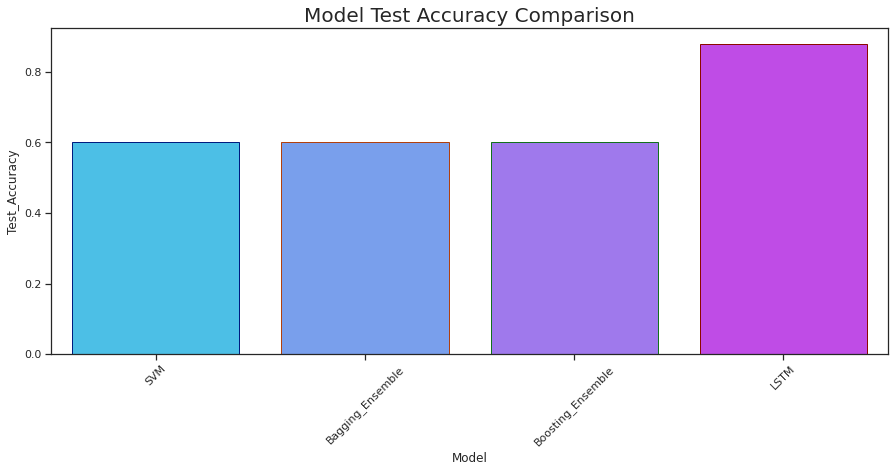

In [126]:
print("\n" + "*"*65 + "\n")
print("-------------------------  MODELS RESULT  ----------------------")
print(result_df)
print("\n" + "*"*65 + "\n")

# Model Comparison - For Training Accuracy
plt.figure(1)
plt.subplots(figsize=(15,6))
sns.barplot(x="Model", y="Test_Accuracy",data=result_df,palette='cool',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=45)
plt.title('Model Test Accuracy Comparison', fontsize=20)
plt.show()
# plt.xlabel(result_df["Model"], fontsize=18)
